### 周波数が低⇒高を10回繰り返す音声波形を生成（データ処理コード）

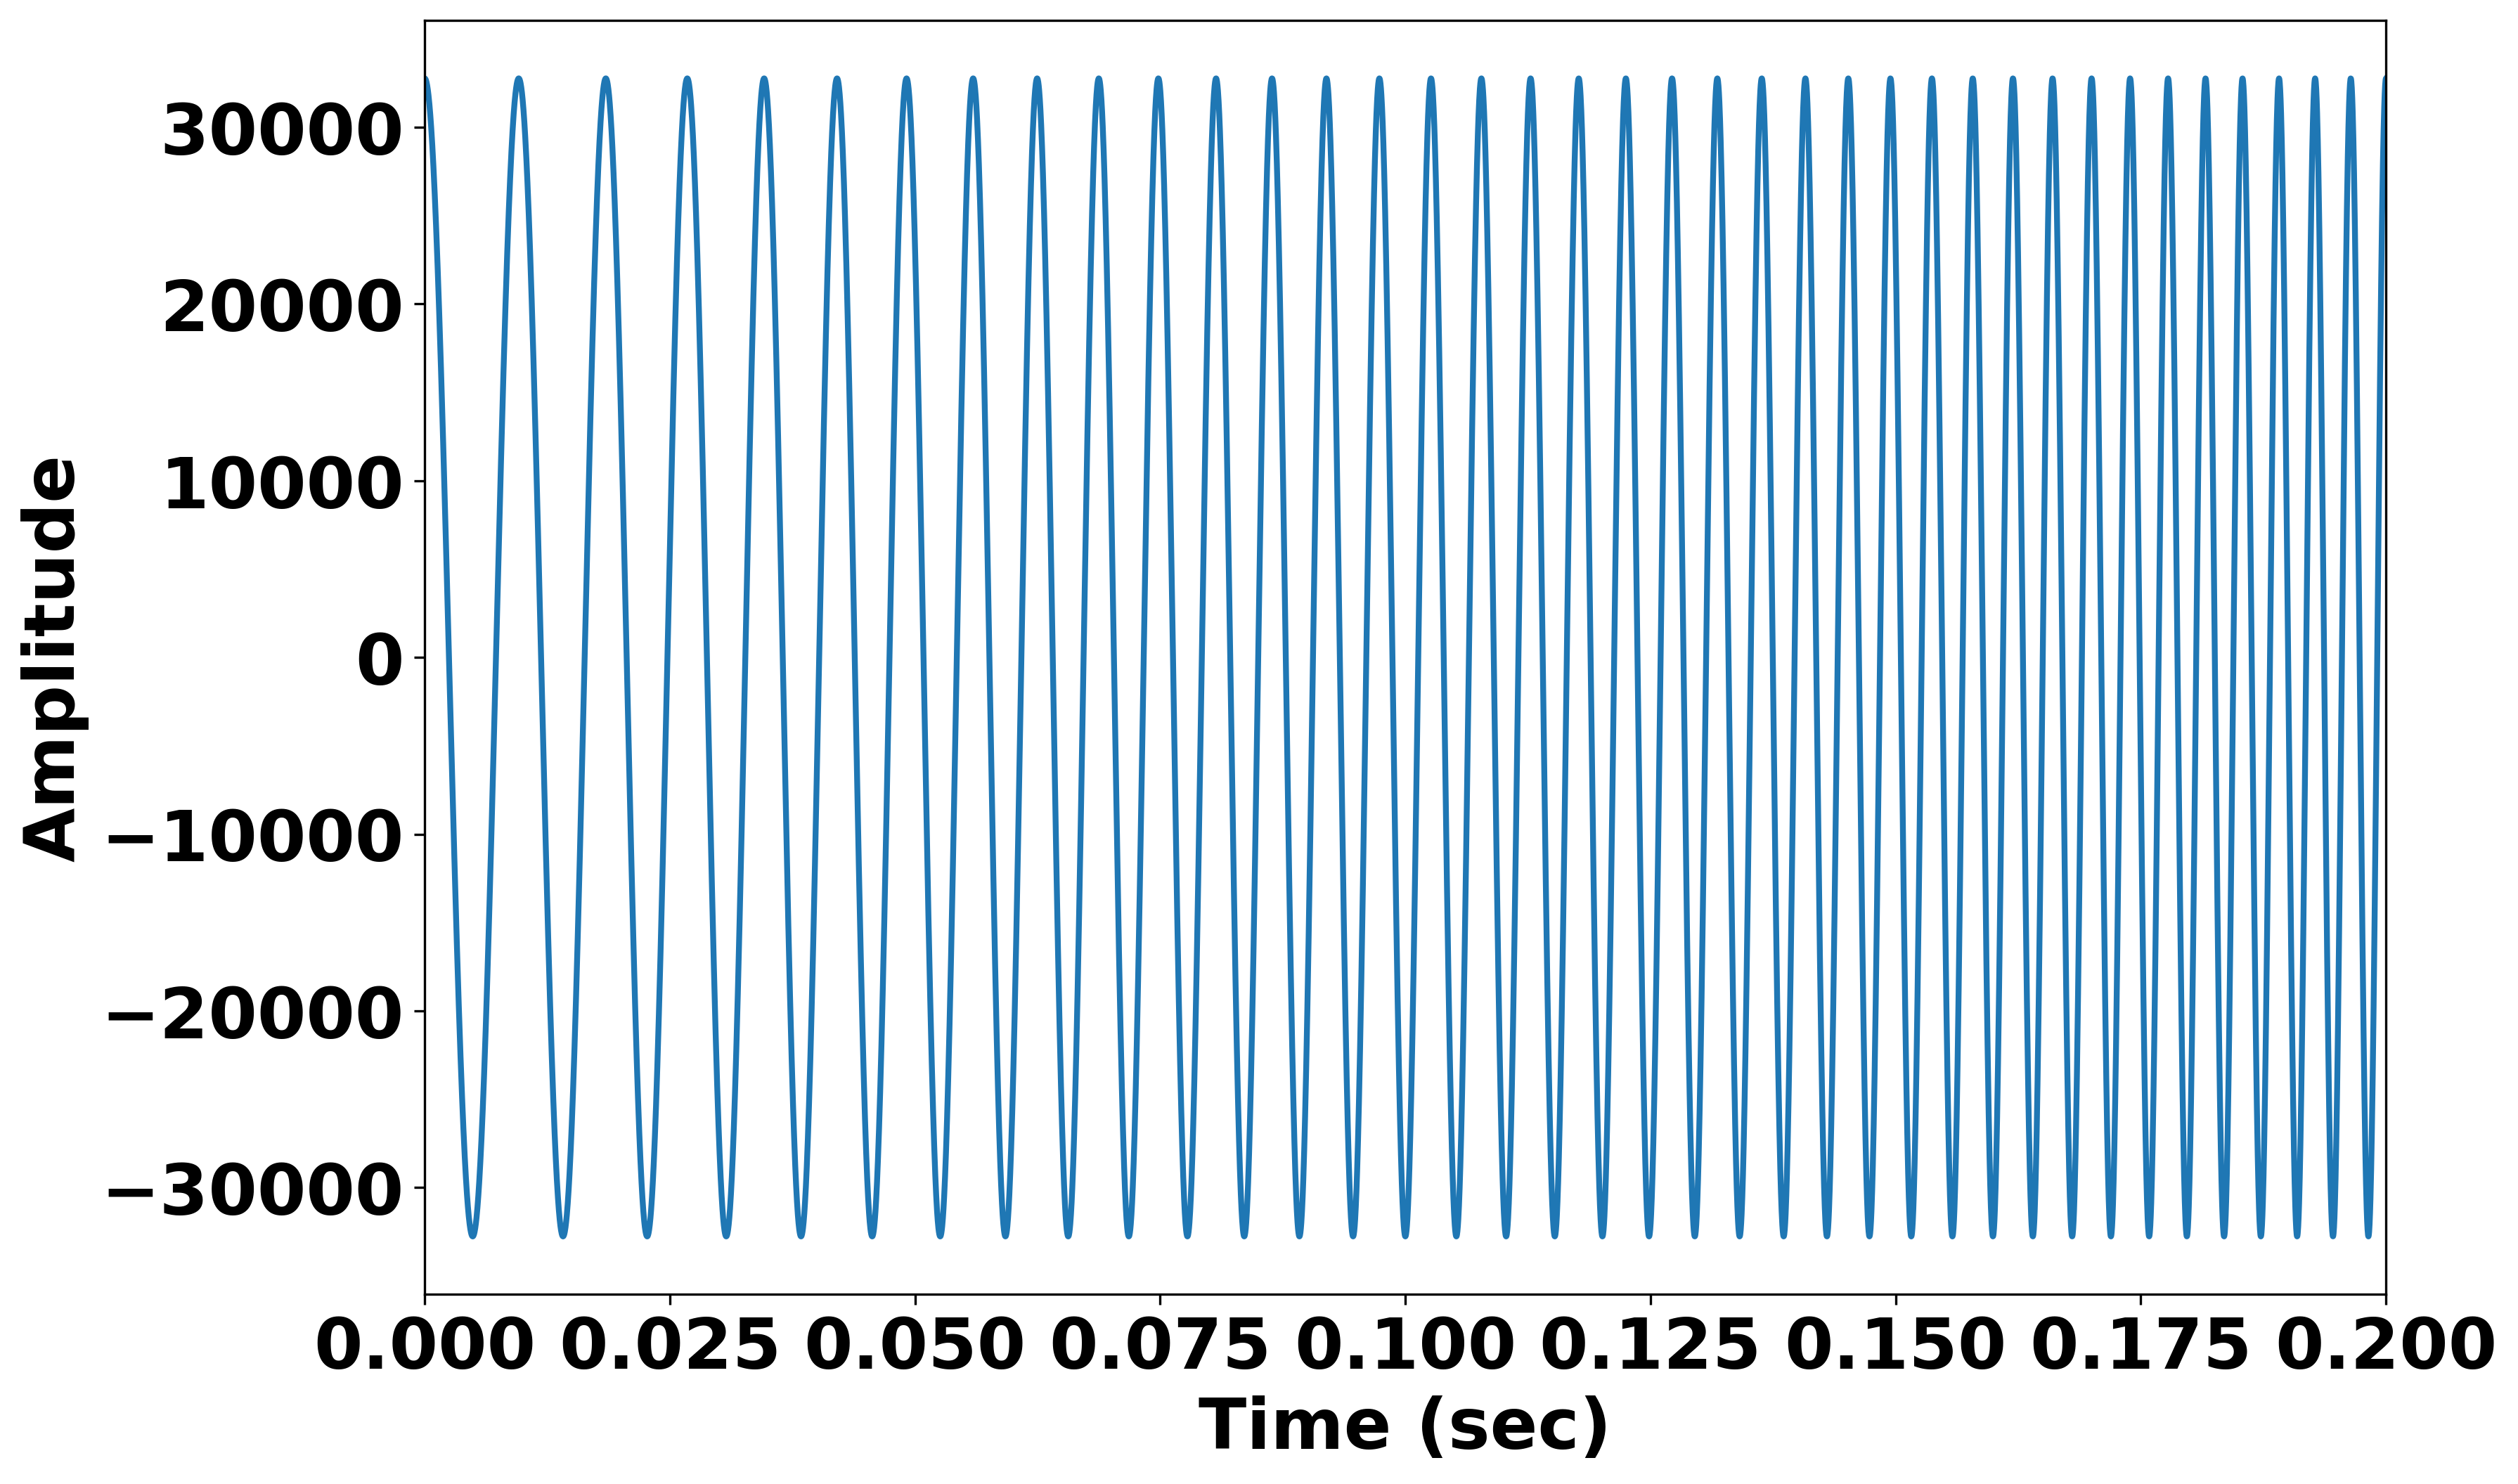

In [7]:
# 周波数が低⇒高を10回繰り返す音声波形を生成
import numpy as np
from scipy.signal import chirp
from scipy.io.wavfile import write
import matplotlib.pyplot as plt

duration = 1            # 継続時間(s)
samplerate = 44100 # サンプリングレート(サンプル/s)
amplitude = np.iinfo(np.int16).max # 振幅最大値
t = np.linspace(0., duration, int(duration*samplerate))
# 100Hz から 1kHzまで、周波数が低⇒高となる波形を生成
data = amplitude * chirp(t, f0=100, f1=1000,
             t1=duration, method='linear')
# 波形を図示
plt.rcParams["font.size"] = 24
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.figure(figsize=(12,8), dpi=300 )
plt.plot(t, data, lw=2, alpha=1)
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude")
plt.xlim([0,0.2])
plt.show()

# 「10回繰り返す」音声を.wavファイルに保存
data = np.array([data for _ in range(10)]).flatten()
write(filename="Sweep.wav",
      rate=samplerate, data=data.astype(np.int16))

In [ ]:
# 周波数が低⇒高を10回繰り返す音声波形を生成
import numpy as np
from scipy.signal import chirp
from scipy.io.wavfile import write
import matplotlib.pyplot as plt

duration = 1       # 継続時間(s)
samplerate = 44100 # サンプリングレート(サンプル/s)
amplitude = np.iinfo(np.int16).max # 振幅最大値
t = np.linspace(0., duration, int(duration*samplerate))
# 100Hz から 1kHzまで、周波数が低⇒高となる波形を生成
data = amplitude * chirp(t, f0=100, f1=1000,
             t1=duration, method='linear')
# 波形を図示
plt.figure()
plt.plot(t, data, lw=2, alpha=1)
plt.xlabel("Time (sec)"); plt.ylabel("Amplitude")
plt.xlim([0,0.2]); plt.show()

# 「10回繰り返す」音声を.wavファイルに保存
data = np.array([data for _ in range(10)]).flatten()
write(filename="Sweep.wav",
      rate=samplerate, data=data.astype(np.int16))

### コード図用（最低限の部分だけ）

### スペクトログラムを図示する

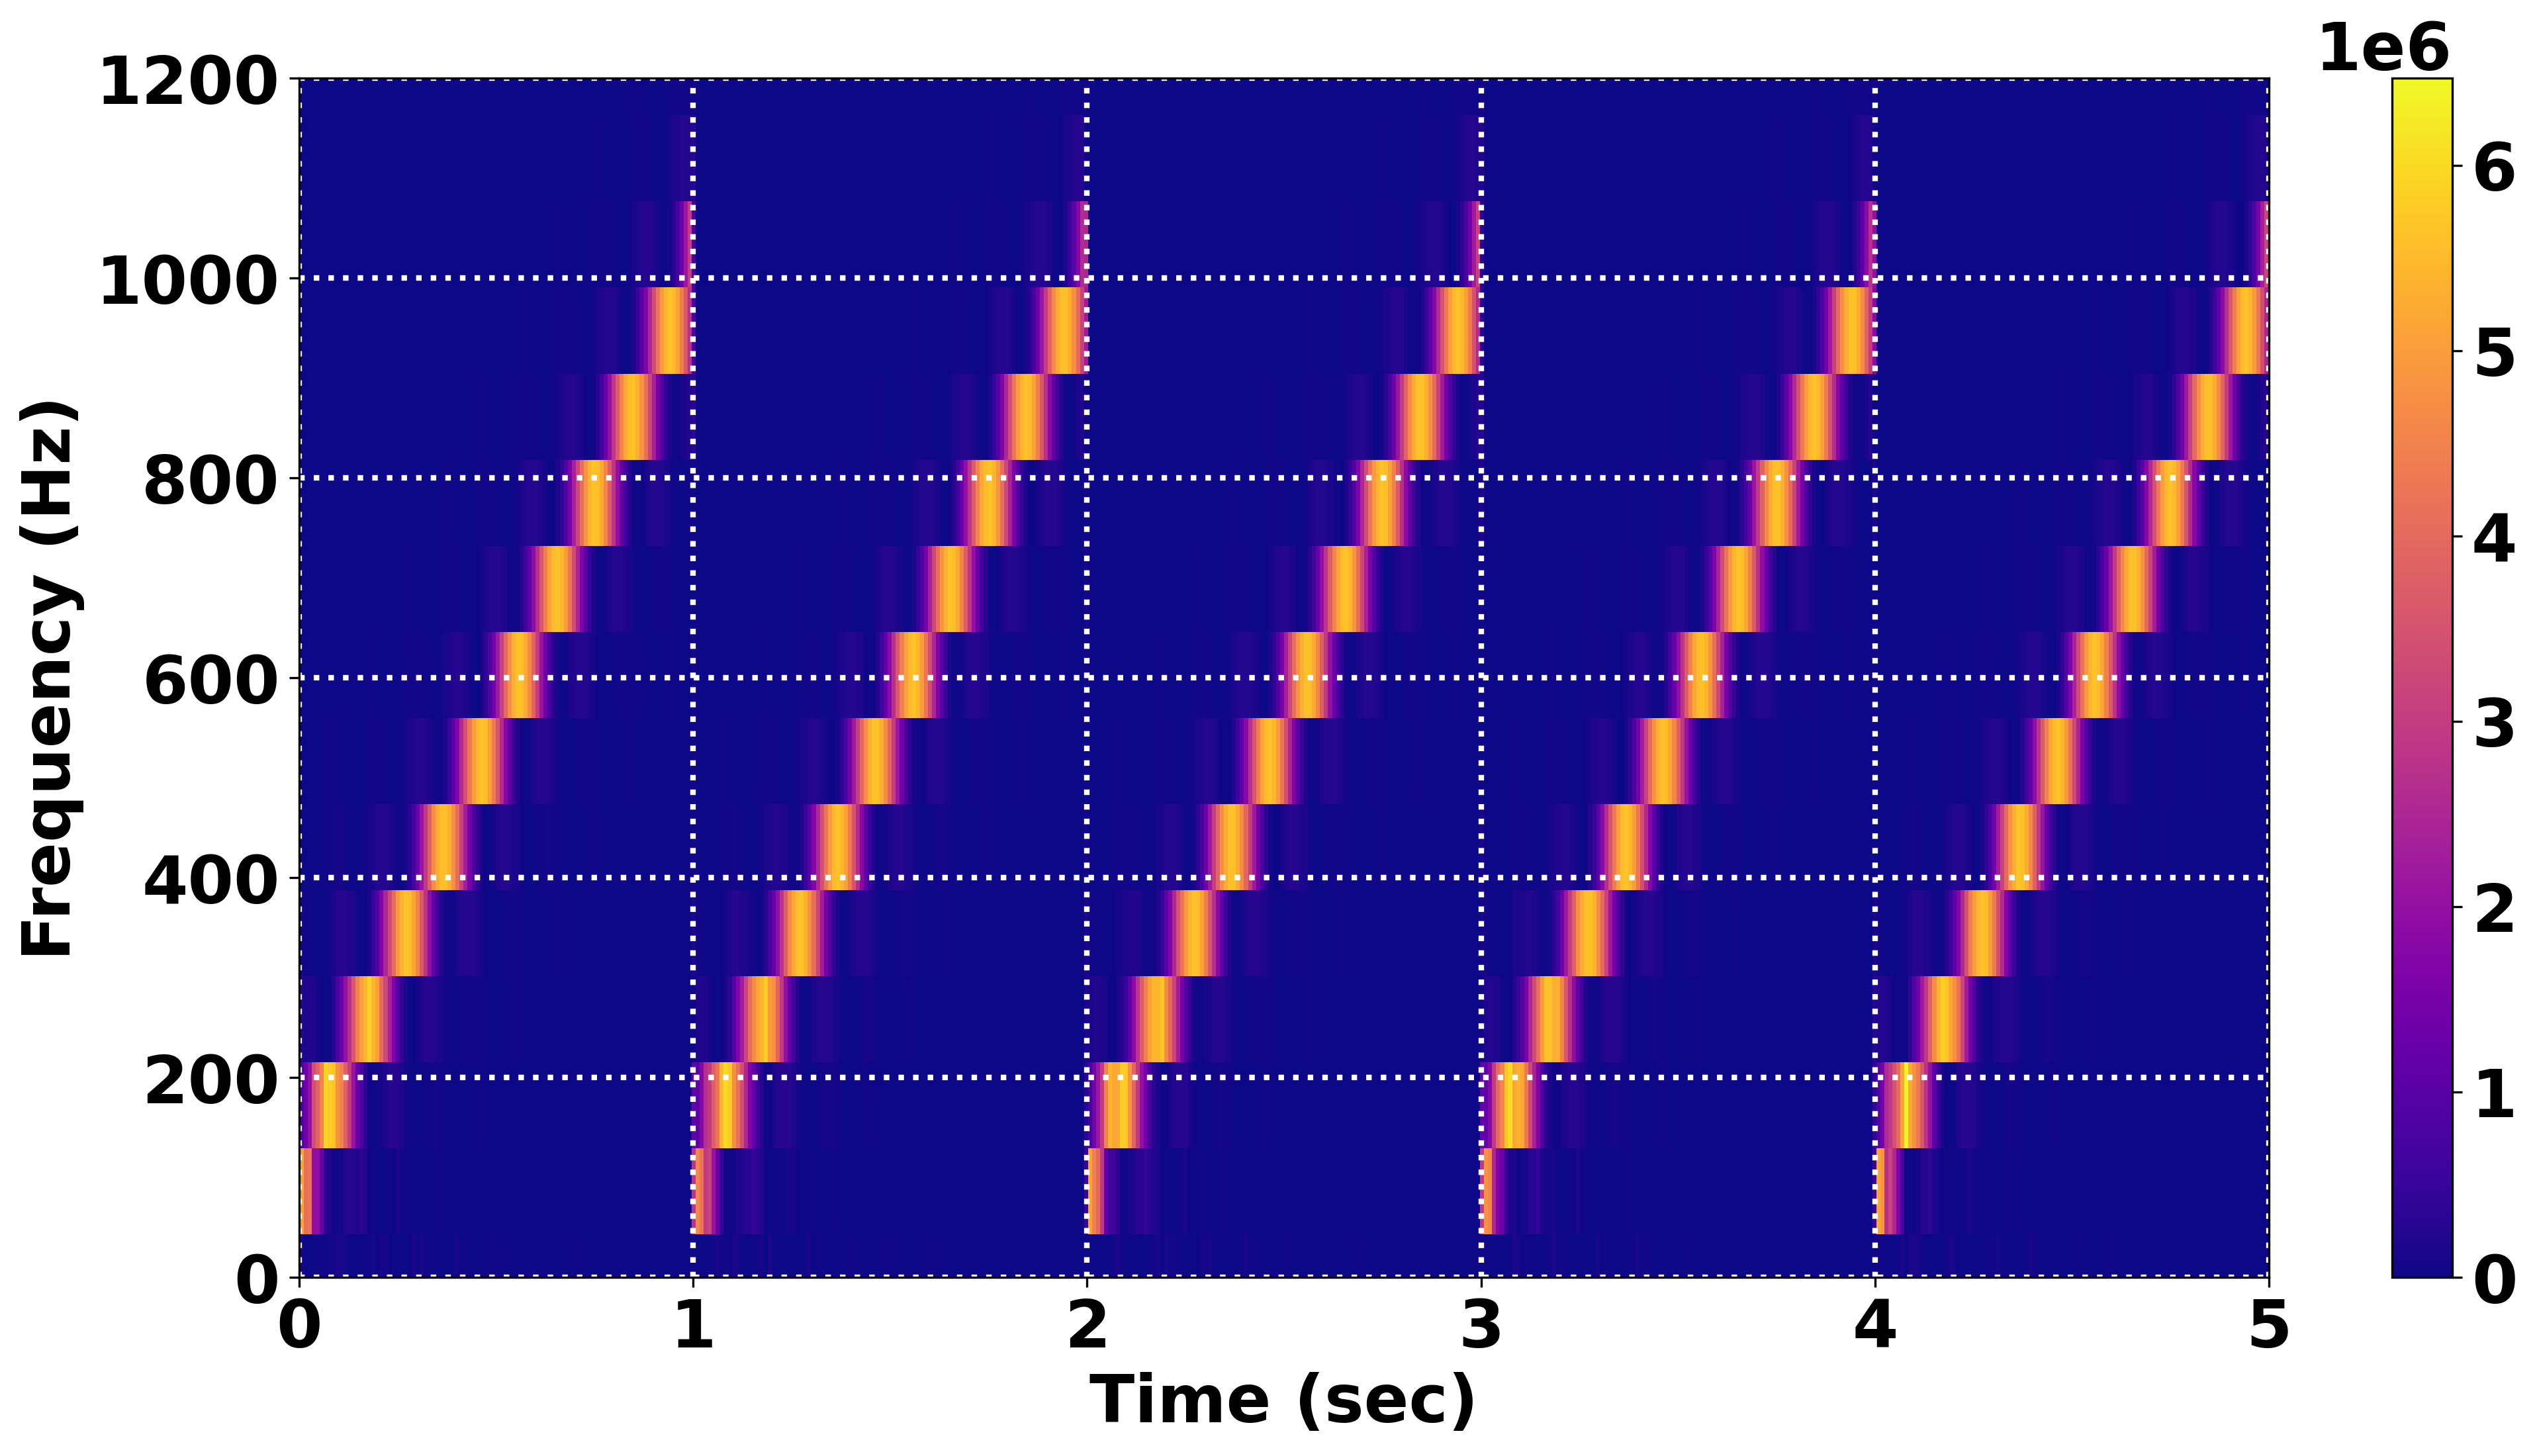

In [5]:
from scipy import signal
from matplotlib import cm
plt.rcParams["image.cmap"] = "plasma"
# スペクトログラムを図示する
f,t,Sxx = signal.spectrogram(data, samplerate, nperseg=512) # 4*4096
plt.rcParams["font.size"] = 24
plt.figure(figsize=(16,8),dpi=300)
plt.pcolormesh(t,f,Sxx)
plt.grid(color='white', linestyle='dotted', linewidth=2)
plt.xlim([0,5])
plt.ylim([0,1200])
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.colorbar()
plt.show()

### コード図用（最低限の部分だけ）

In [ ]:
from scipy import signal
from matplotlib import cm

# スペクトログラムを図示する
f,t,Sxx = signal.spectrogram(data, 
                             samplerate, nperseg=512)
plt.figure(); plt.pcolormesh(t,f,Sxx)
plt.xlim([0,5]); plt.ylim([0,1200])
plt.xlabel("Time (sec)"); plt.ylabel("Frequency (Hz)")
plt.colorbar(); plt.show()

### 240FPS撮影動画から音声波形を作成する（データ処理部）

In [6]:
import cv2

vidcap=cv2.VideoCapture('sweep_sound.mov') # 動画を開く
success, img=vidcap.read()
h, w, c = img.shape # [1080, 1920, 3] 1920×1080のBGR画像

sig = []       # 刻々の画素値リストを格納する「揺れ信号リスト」
# 冒頭フレームから「左右真ん中を上下１列」を読み込む
# 差分演算をするため、画素値(uint)はfloatに型変換する
offset = img[:,int(w/2),1].astype(float)
while success: #「左右真ん中を上下１列」を（冒頭との差分）で追加
    sig.append( img[:,int(w/2),1].astype(float) - offset ) 
    success, img = vidcap.read()

/Users/jun/.espressif/python_env/idf5.0_py3.7_env/lib/python3.7/site-packages/numpy/lib/polynomial.py:658: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/jun/.espressif/python_env/idf5.0_py3.7_env/lib/python3.7/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/jun/.espressif/python_env/idf5.0_py3.7_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


(-4.0, 4.0)

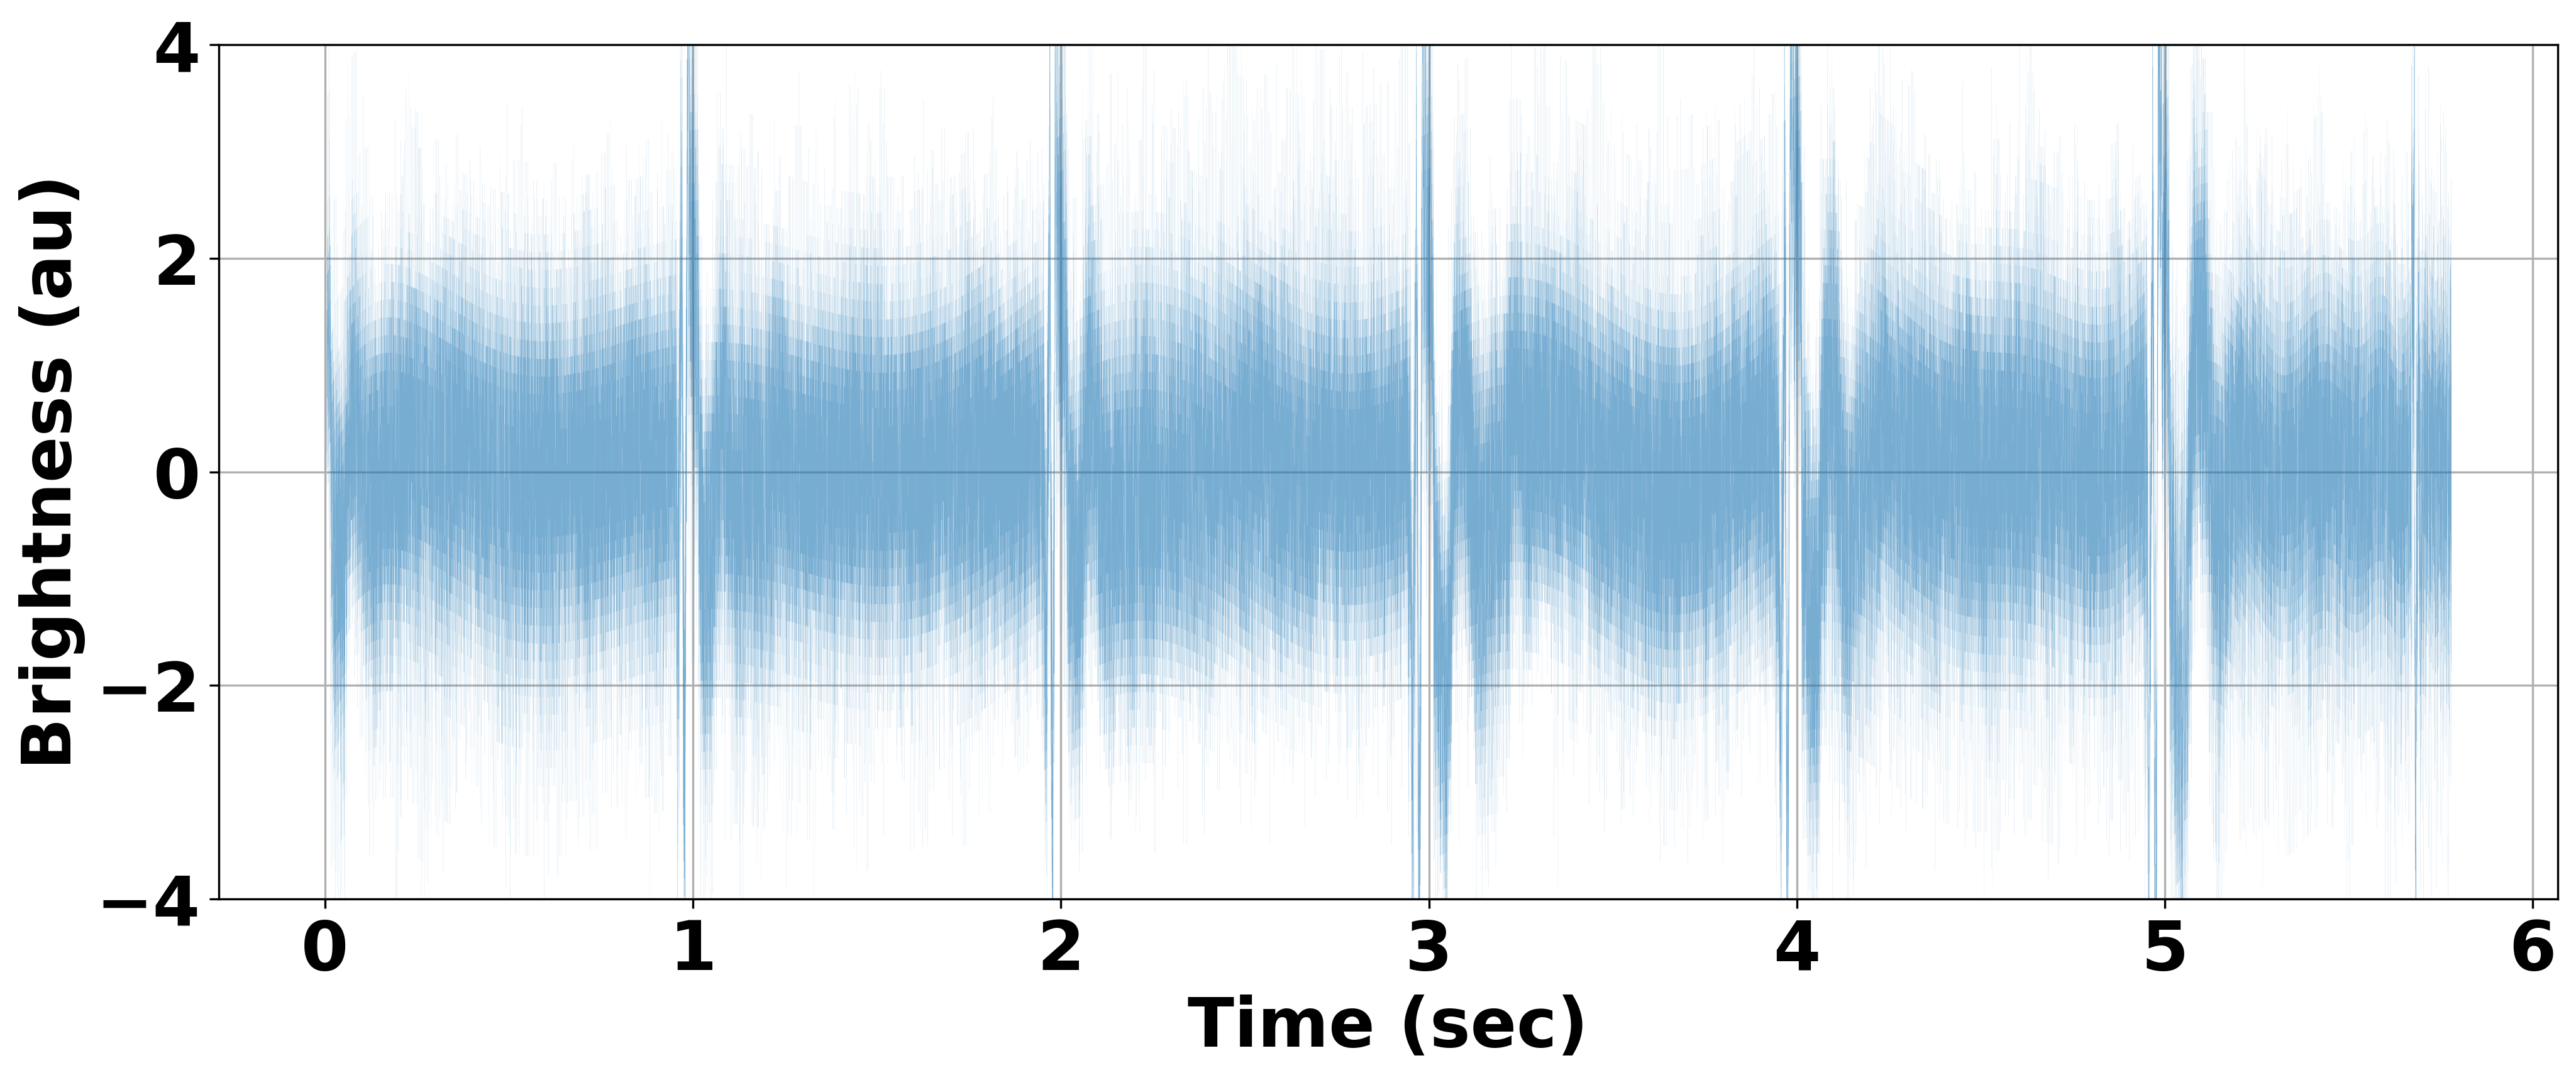

In [17]:
# この時点では 240 frame/sec * 1080 point = 259.200 kHz
sig = np.array(sig).flatten() # 画素値を一次元に並べる
data = np.convolve(sig, np.ones(6)/6, mode='same')
data = data[::6] # 259.200 kHz / 6 = 43.2kHz になる
x = np.arange(0, 1/240/h*6*len(data), 1/240/h*6)

# 緩やかな変化を（低次の多項式近似で減算して）取り除く
fit = np.poly1d( np.polyfit(x, data, 256))
data = (data-fit(x))

plt.rcParams["font.size"] = 26
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.figure(figsize=(16,6), dpi=300)
plt.grid()
plt.plot(x, data, lw=0.02, alpha=0.6)
plt.xlabel("Time (sec)")
plt.ylabel("Brightness (au)")
#plt.xlim([0.1,0.41])
plt.ylim([-4.,4.])

## 記事貼り用

In [ ]:
import cv2

vidcap=cv2.VideoCapture('sweep_sound.mov') # 動画を開く
success, img=vidcap.read()
h, w, c = img.shape # [1080, 1920, 3] 1920×1080のBGR画像

sig = []       # 刻々の画素値リストを格納する「揺れ信号リスト」
# 冒頭フレームから「左右真ん中を上下１列」を読み込む
# 差分演算をするため、画素値(uint)はfloatに型変換する
offset = img[:,int(w/2),1].astype(float)
while success: #「左右真ん中を上下１列」を（冒頭との差分）で追加
    sig.append( img[:,int(w/2),1].astype(float) - offset ) 
    success, img = vidcap.read()

# この時点では 240 frame/sec * 1080 point = 259.200 kHz
sig = np.array(sig).flatten() # 画素値を一次元に並べる
data = np.convolve(sig, np.ones(6)/6, mode='same')
data = data[::6] # 259.200 kHz / 6 = 43.2kHz になる
x = np.arange(0, 1/240/h*6*len(data), 1/240/h*6)

# 緩やかな変化を（低次の多項式近似で減算して）取り除く
fit = np.poly1d( np.polyfit(x, data, 256))
data = (data-fit(x))
# 輝度変動を折れ線グラフにする
plt.figure(); plt.plot(x, data, lw=1, alpha=1)
plt.xlabel("Time (sec)"); plt.ylabel("Brightness (au)")

# 1秒あたりのデータ・サンプル数を設定
samplerate = int(240 * h / 6)
# スペクトログラムを作成・図示
f,t,Sxx = signal.spectrogram(data, samplerate, nperseg=512)
plt.pcolormesh(t,f,Sxx,vmax=0.001)
plt.xlabel("Time (sec)"); plt.ylabel("Frequency (Hz)")
plt.colorbar(); plt.show()

# 音声(.wav)ファイルとして保存
write(filename="Eavesdropping.wav", rate=samplerate, 
      data=(data/10.0*amplitude).astype(np.int16))

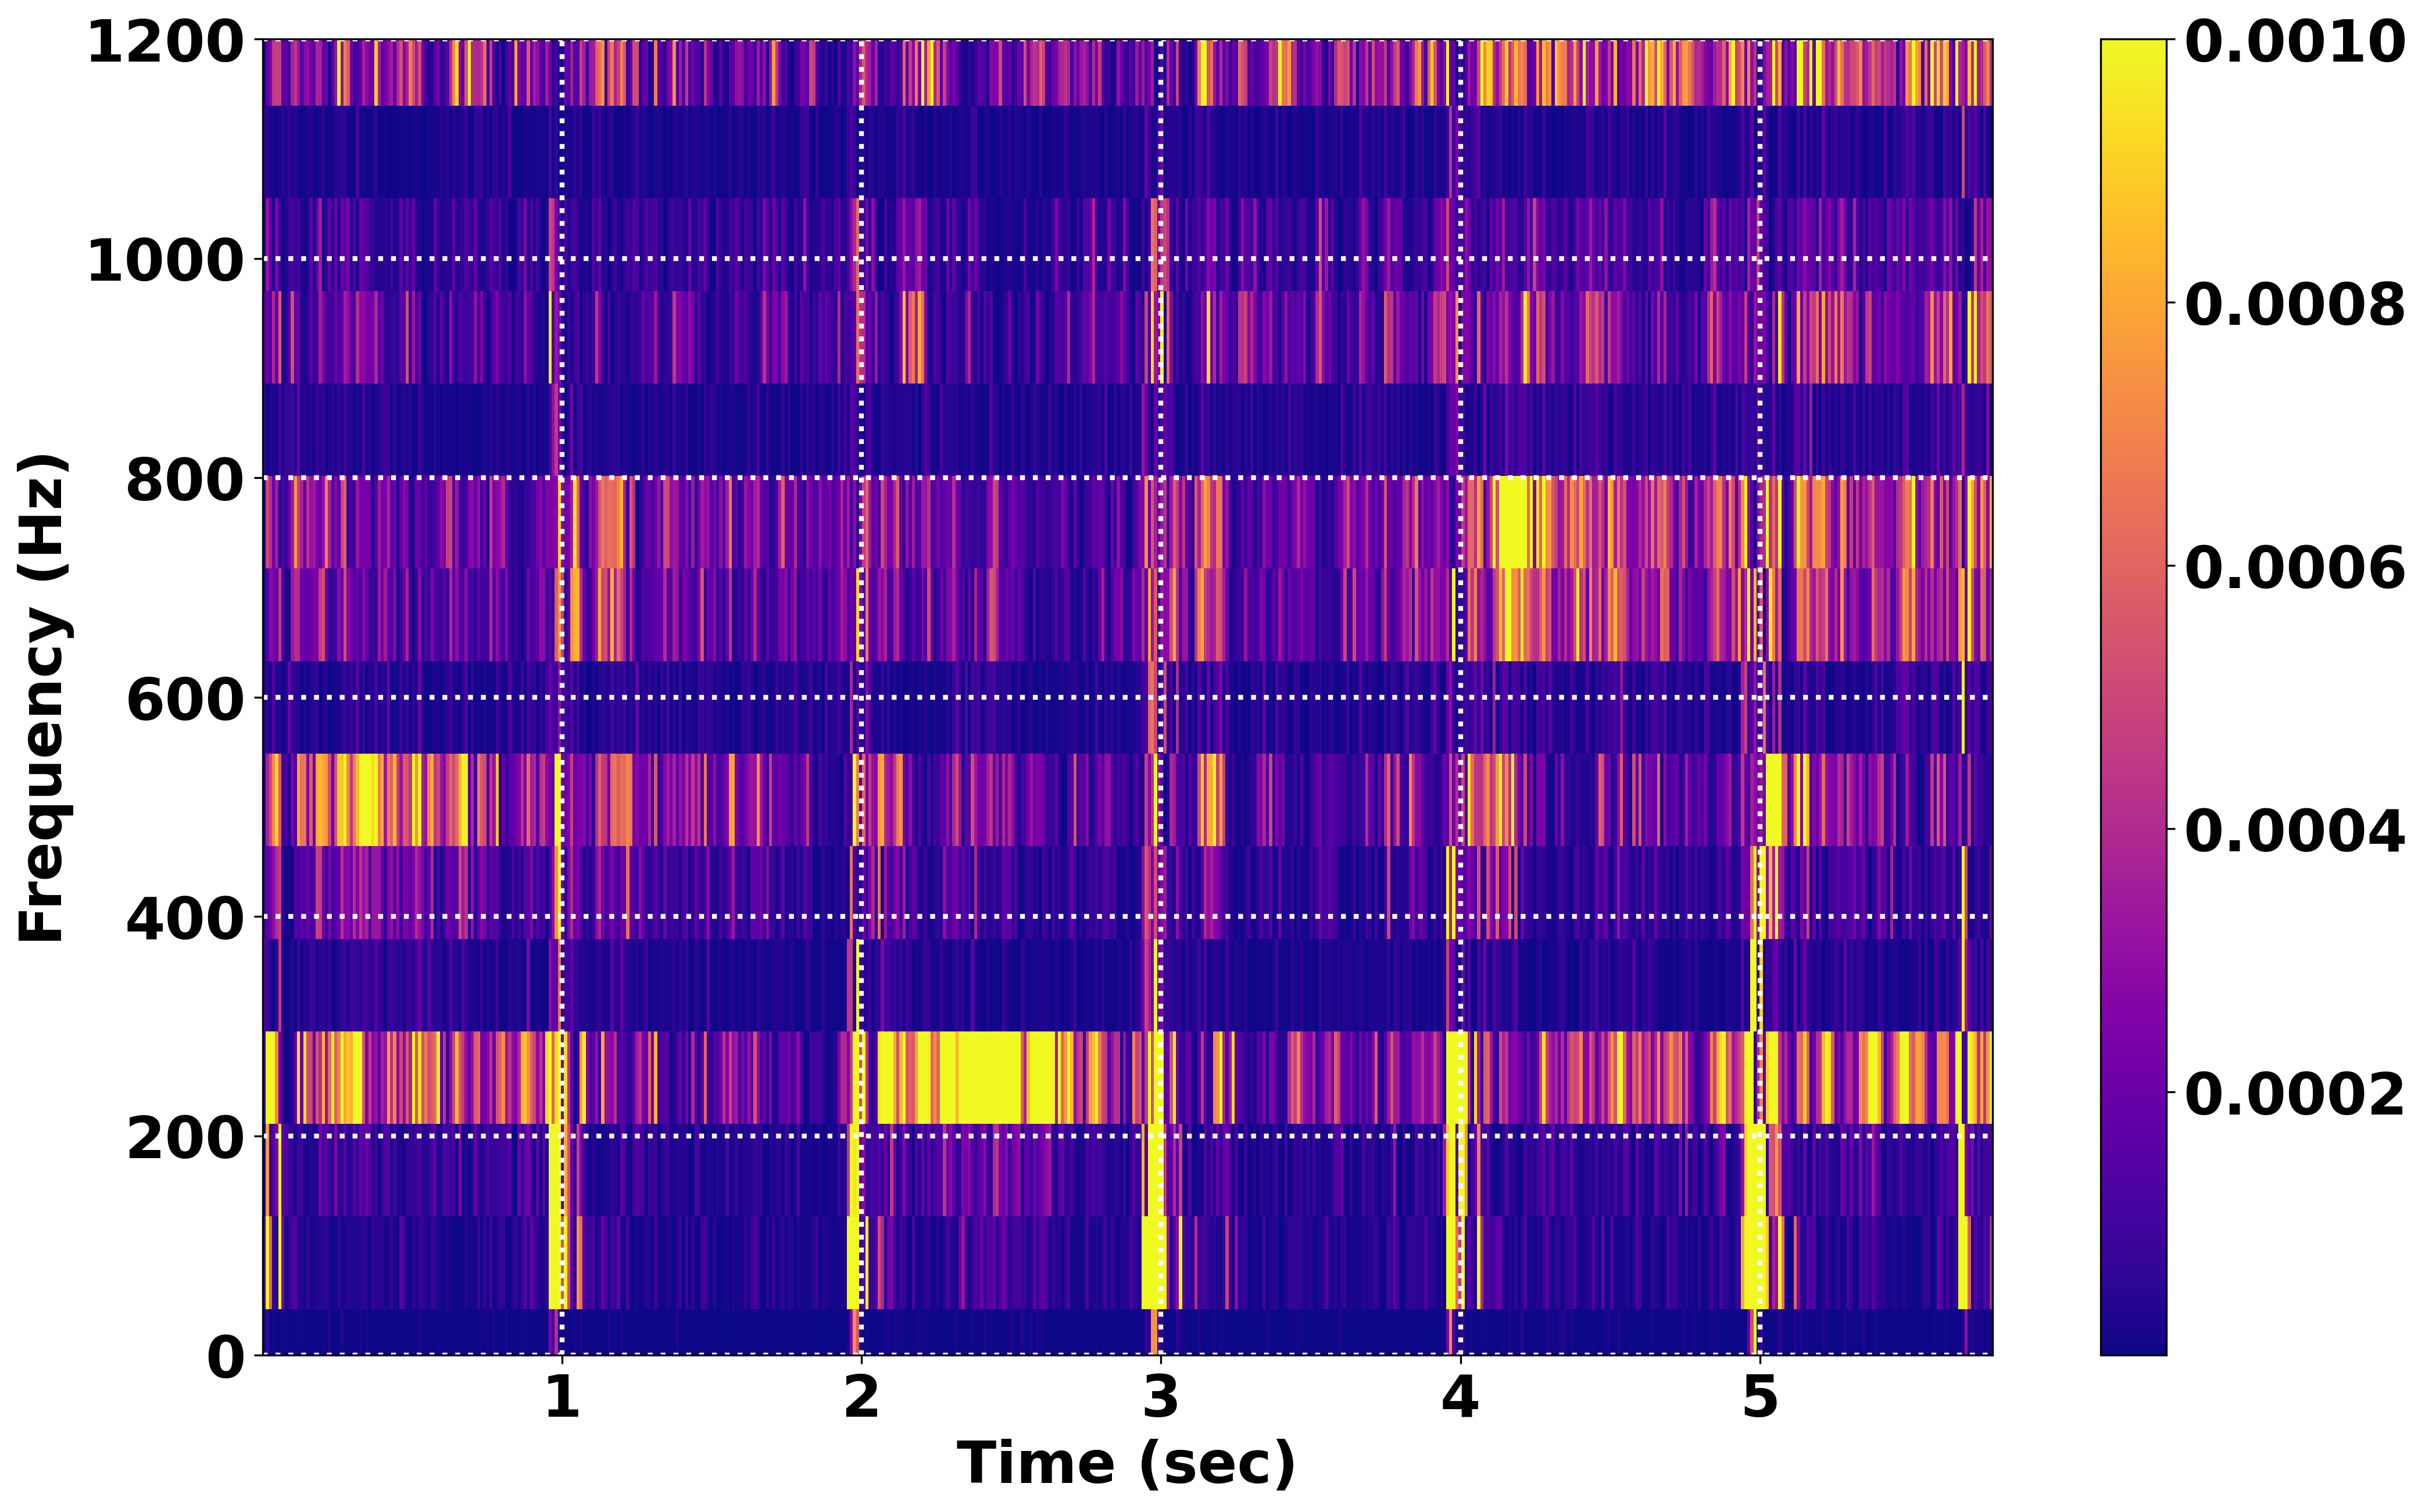

In [63]:
# 1秒あたりのデータ・サンプル数を設定
samplerate = int(240 * h / 6)
# スペクトログラムを作成・図示
f,t,Sxx = signal.spectrogram(data, 
            samplerate, nperseg=512)
plt.rcParams["font.size"] = 24
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.figure(figsize=(16,10), dpi=300)
plt.pcolormesh(t,f,Sxx,vmax=0.001)
plt.grid(color='white', linestyle='dotted', linewidth=2)
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.ylim([0,1200])
plt.colorbar()
plt.show()

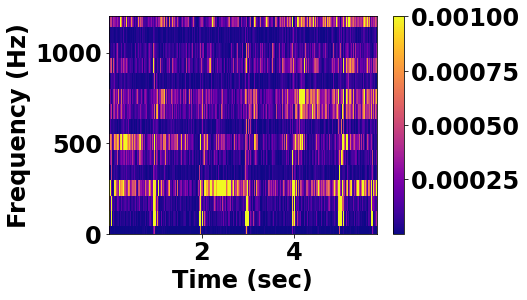

In [62]:
# 1秒あたりのデータ・サンプル数を設定
samplerate = int(240 * h / 6)
# スペクトログラムを作成・図示
f,t,Sxx = signal.spectrogram(data, 
            samplerate, nperseg=512)
plt.figure()
plt.pcolormesh(t,f,Sxx,vmax=0.001)
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.ylim([0,1200])
plt.colorbar()
plt.show()